In [46]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

BASE_PATH = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train"
cls = ["COVID-19", "Non-COVID", "Normal"]
save_path = "/kaggle/working/"

# COVID - 19

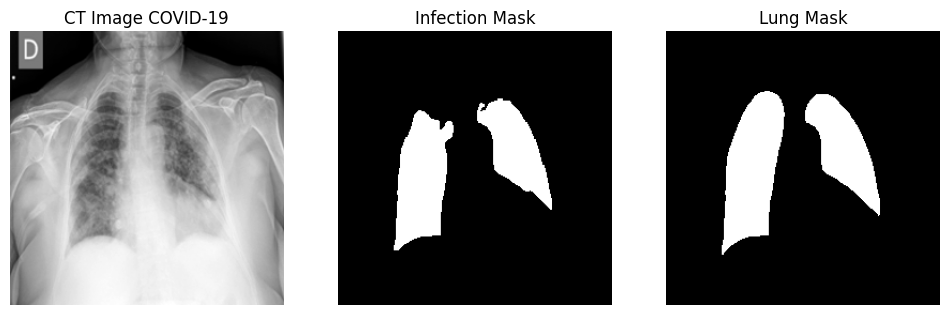

In [47]:
img_dir = os.path.join(BASE_PATH, cls[0], 'images')
infect_covid_dir = os.path.join(BASE_PATH, cls[0], 'infection masks')
lung_covid_dir = os.path.join(BASE_PATH, cls[0], 'lung masks')

img_covid_name = random.choice(os.listdir(img_dir))

img_covid = Image.open(os.path.join(img_dir, img_covid_name))
infect_covid = Image.open(os.path.join(infect_covid_dir, img_covid_name))
lung_covid = Image.open(os.path.join(lung_covid_dir,img_covid_name))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_covid, cmap='gray')
plt.title(f"CT Image {cls[0]}")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(infect_covid, cmap='gray')
plt.title("Infection Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(lung_covid, cmap='gray')
plt.title("Lung Mask")
plt.axis("off")

plt.savefig(os.path.join(save_path,'covid.png'))
plt.show()

# Non - COVID

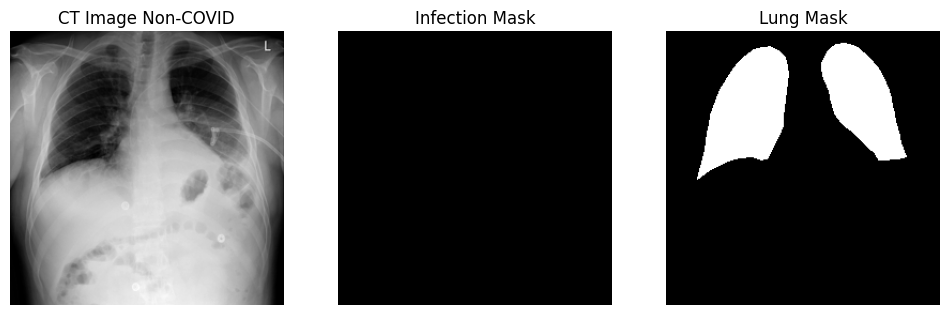

In [48]:
img_dir_non = os.path.join(BASE_PATH, cls[1], 'images')
infect_covid_dir_non = os.path.join(BASE_PATH, cls[1], 'infection masks')
lung_covid_dir_non = os.path.join(BASE_PATH, cls[1], 'lung masks')

img_non_covid_name = random.choice(os.listdir(img_dir_non))

img_non_covid = Image.open(os.path.join(img_dir_non, img_non_covid_name))
infect_non_covid = Image.open(os.path.join(infect_covid_dir_non, img_non_covid_name))
lung_non_covid = Image.open(os.path.join(lung_covid_dir_non,img_non_covid_name))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_non_covid, cmap='gray')
plt.title(f"CT Image {cls[1]}")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(infect_non_covid, cmap='gray')
plt.title("Infection Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(lung_non_covid, cmap='gray')
plt.title("Lung Mask")
plt.axis("off")

plt.savefig(os.path.join(save_path, "non-covid.png"))
plt.show()

# NORMAL

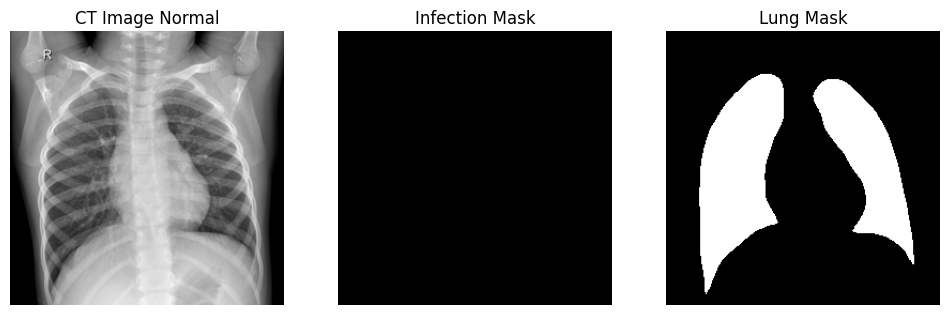

In [49]:
img_normal_dir = os.path.join(BASE_PATH, cls[2], 'images')
infect_normal_dir = os.path.join(BASE_PATH, cls[2], 'infection masks')
lung_normal_dir = os.path.join(BASE_PATH, cls[2], 'lung masks')

img_normal_name = random.choice(os.listdir(img_normal_dir))

img_normal = Image.open(os.path.join(img_normal_dir, img_normal_name))
infect_normal = Image.open(os.path.join(infect_normal_dir, img_normal_name))
lung_normal = Image.open(os.path.join(lung_normal_dir,img_normal_name))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_normal, cmap='gray')
plt.title(f"CT Image {cls[2]}")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(infect_normal, cmap='gray')
plt.title("Infection Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(lung_normal, cmap='gray')
plt.title("Lung Mask")
plt.axis("off")

plt.savefig(os.path.join(save_path, "normal.png"))
plt.show()

In [20]:
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.ToTensor(),            
    transforms.Normalize(mean=[0.5], std=[0.5])
])

mask_transform = transforms.Compose([
    transforms.ToTensor()              
])


In [21]:
class CovidSegmentationDataset(Dataset):
    def __init__(self, root_dir, image_transform=None, mask_transform=None):
        self.samples = []
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        classes = ["COVID-19", "Non-COVID", "Normal"]

        for cls in classes:
            img_dir = os.path.join(root_dir, cls, "images")
            lung_dir = os.path.join(root_dir, cls, "lung masks")
            inf_dir  = os.path.join(root_dir, cls, "infection masks")

            for name in os.listdir(img_dir):
                self.samples.append((
                    os.path.join(img_dir, name),
                    os.path.join(lung_dir, name),
                    os.path.join(inf_dir, name)
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, lung_path, inf_path = self.samples[idx]

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        lung  = cv2.imread(lung_path, cv2.IMREAD_GRAYSCALE)
        inf   = cv2.imread(inf_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (256,256))
        lung  = cv2.resize(lung, (256,256))
        inf   = cv2.resize(inf, (256,256))

        lung = (lung > 0).astype(np.float32)
        inf  = (inf > 0).astype(np.float32)

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            lung = self.mask_transform(lung)
            inf  = self.mask_transform(inf)

        mask = torch.cat([lung, inf], dim=0)   # (2,H,W)

        return image, mask


In [22]:
train_root = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train"
val_root   = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val"

train_dataset = CovidSegmentationDataset(
    train_root, image_transform, mask_transform
)

val_dataset = CovidSegmentationDataset(
    val_root, image_transform, mask_transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [23]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = DoubleConv(1, 64)
        self.p1 = nn.MaxPool2d(2)
        self.e2 = DoubleConv(64, 128)
        self.p2 = nn.MaxPool2d(2)
        self.e3 = DoubleConv(128, 256)
        self.p3 = nn.MaxPool2d(2)

        self.b = DoubleConv(256, 512)

        self.u3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.d3 = DoubleConv(512, 256)
        self.u2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.d2 = DoubleConv(256, 128)
        self.u1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.d1 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, 2, 1)

    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(self.p1(e1))
        e3 = self.e3(self.p2(e2))

        b = self.b(self.p3(e3))
        d3 = self.d3(torch.cat([self.u3(b), e3], dim=1))
        d2 = self.d2(torch.cat([self.u2(d3), e2], dim=1))
        d1 = self.d1(torch.cat([self.u1(d2), e1], dim=1))

        return self.out(d1)


In [24]:
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def iou_score(pred, target, smooth=1e-6):
    pred = (torch.sigmoid(pred) > 0.5).float()
    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) - intersection
    return ((intersection + smooth) / (union + smooth)).mean()


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)



cuda


In [27]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = dice_loss

epochs = 30

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = model(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    dice, iou = 0, 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            dice += 1 - dice_loss(preds, masks).item()
            iou  += iou_score(preds, masks).item()

    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Loss: {train_loss/len(train_loader):.4f} | "
        f"Dice: {dice/len(val_loader):.4f} | "
        f"IoU: {iou/len(val_loader):.4f}"
    )

Epoch [1/30] | Loss: 0.5554 | Dice: 0.5157 | IoU: 0.5605
Epoch [2/30] | Loss: 0.4388 | Dice: 0.5968 | IoU: 0.6037
Epoch [3/30] | Loss: 0.3874 | Dice: 0.6374 | IoU: 0.6141
Epoch [4/30] | Loss: 0.3644 | Dice: 0.6444 | IoU: 0.6116
Epoch [5/30] | Loss: 0.3532 | Dice: 0.6519 | IoU: 0.6141
Epoch [6/30] | Loss: 0.3463 | Dice: 0.6618 | IoU: 0.6223
Epoch [7/30] | Loss: 0.3419 | Dice: 0.6598 | IoU: 0.6168
Epoch [8/30] | Loss: 0.3378 | Dice: 0.6682 | IoU: 0.6279
Epoch [9/30] | Loss: 0.3345 | Dice: 0.6710 | IoU: 0.6327
Epoch [10/30] | Loss: 0.3331 | Dice: 0.6708 | IoU: 0.6290
Epoch [11/30] | Loss: 0.3305 | Dice: 0.6717 | IoU: 0.6304
Epoch [12/30] | Loss: 0.3278 | Dice: 0.6731 | IoU: 0.6303
Epoch [13/30] | Loss: 0.3286 | Dice: 0.6742 | IoU: 0.6467
Epoch [14/30] | Loss: 0.3245 | Dice: 0.6752 | IoU: 0.6348
Epoch [15/30] | Loss: 0.3225 | Dice: 0.6743 | IoU: 0.6367
Epoch [16/30] | Loss: 0.3202 | Dice: 0.6638 | IoU: 0.6380
Epoch [17/30] | Loss: 0.3193 | Dice: 0.6704 | IoU: 0.6416
Epoch [18/30] | Loss: 0

In [28]:
model_path = "/kaggle/working/unet_covid_segmentation.pth"
torch.save(model.state_dict(), model_path)

print("Model saved to:", model_path)


Model saved to: /kaggle/working/unet_covid_segmentation.pth


In [29]:
model = UNet().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()


UNet(
  (e1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (p2):

In [40]:
def evaluate_model(model, dataloader, device="cuda"):
    model.eval()

    dice_lung = 0.0
    iou_lung = 0.0
    dice_inf = 0.0
    iou_inf = 0.0
    n_batches = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)  

            outputs = model(images)    

            probs = torch.sigmoid(outputs)

            preds = (probs > 0.5).float()
            
            dice_lung += dice_loss(preds[:, 0:1], masks[:, 0:1]).item()
            iou_lung  += iou_score(preds[:, 0:1], masks[:, 0:1]).item()

            dice_inf += dice_loss(preds[:, 1:2], masks[:, 1:2]).item()
            iou_inf  += iou_score(preds[:, 1:2], masks[:, 1:2]).item()

            n_batches += 1

    return {
        "Dice Lung": dice_lung / n_batches,
        "IoU Lung": iou_lung / n_batches,
        "Dice Infection": dice_inf / n_batches,
        "IoU Infection": iou_inf / n_batches,
    }


In [41]:
test_root = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test"

test_dataset = CovidSegmentationDataset(
    test_root, image_transform, mask_transform
)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

metrics = evaluate_model(model, test_loader)

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


Dice Lung: 0.5737
IoU Lung: 0.9344
Dice Infection: 0.8692
IoU Infection: 0.3421


In [42]:
import os
import cv2
import numpy as np

def load_gt_masks(test_root, image_path):
    """
    Load ground-truth lung & infection masks
    """
    filename = os.path.basename(image_path)

    lung_path = os.path.join(
        test_root, "COVID-19", "lung masks", filename
    )
    inf_path = os.path.join(
        test_root, "COVID-19", "infection masks", filename
    )

    lung = cv2.imread(lung_path, cv2.IMREAD_GRAYSCALE)
    inf  = cv2.imread(inf_path,  cv2.IMREAD_GRAYSCALE)

    if lung is None or inf is None:
        raise FileNotFoundError("Mask not found — check filenames")

    lung = (lung > 0).astype(np.uint8)
    inf  = (inf > 0).astype(np.uint8)

    return lung, inf


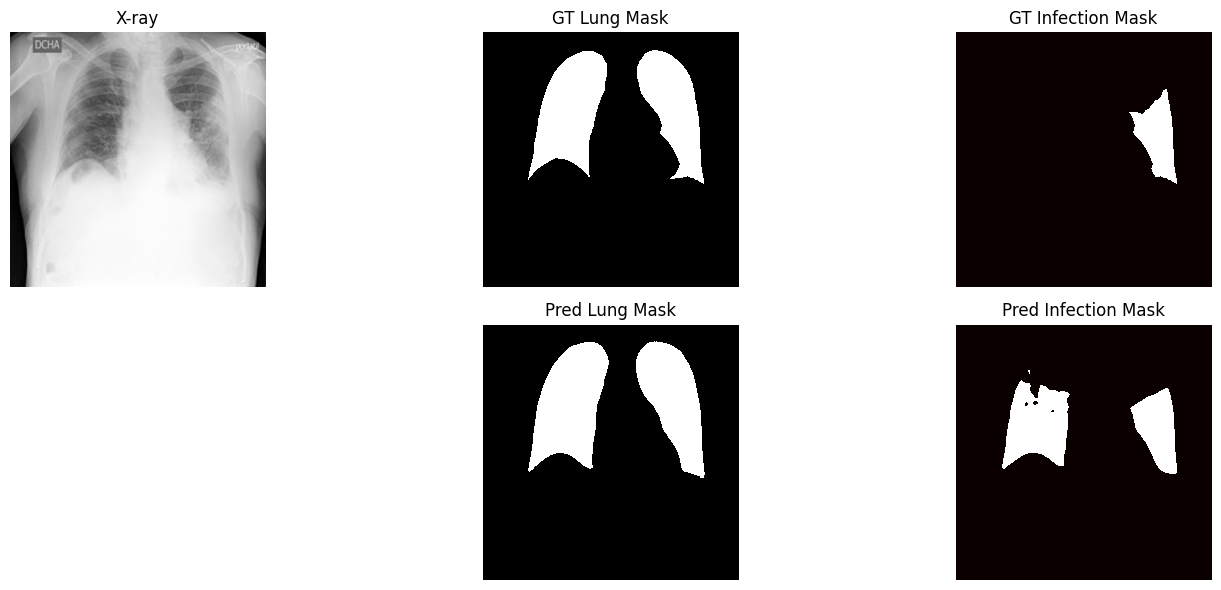

In [51]:
import matplotlib.pyplot as plt

test_root = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test"
image_path = test_root + "/COVID-19/images/covid_1582.png"

img, pred_lung, pred_inf = predict_single_image(image_path, model)

gt_lung, gt_inf = load_gt_masks(test_root, image_path)

plt.figure(figsize=(15,6))

plt.subplot(2,3,1)
plt.imshow(img, cmap="gray")
plt.title("X-ray")
plt.axis("off")

plt.subplot(2,3,2)
plt.imshow(gt_lung, cmap="gray")
plt.title("GT Lung Mask")
plt.axis("off")

plt.subplot(2,3,3)
plt.imshow(gt_inf, cmap="hot")
plt.title("GT Infection Mask")
plt.axis("off")

plt.subplot(2,3,5)
plt.imshow(pred_lung, cmap="gray")
plt.title("Pred Lung Mask")
plt.axis("off")

plt.subplot(2,3,6)
plt.imshow(pred_inf, cmap="hot")
plt.title("Pred Infection Mask")
plt.axis("off")

plt.savefig(os.path.join(save_path,"predcit.png"))
plt.tight_layout()
plt.show()
